In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
np.set_printoptions(precision=2, suppress=True)

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 128

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "series/18-03-24-020248/var7/models/activepolicy-18-03-24-020450/model-6400000.meta" # ok results, no error > 80% usually, usually better than mostcommon
META_FILE = "series/18-03-26-122044/var10-lstm1/models/activepolicy-18-03-26-122222/model-12000000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from series/18-03-26-122044/var10-lstm1/models/activepolicy-18-03-26-122222/model-12800000


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [6]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * BATCH_SIZE, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

1.0 [1.    0.978 1.    1.    1.    0.993 1.    0.994 0.    0.    0.    0.
 0.    0.    0.    0.    0.002 0.    0.    0.   ]


In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 400; avg step: 3.81; stdev step: 1.25; avg error: 0.68; stdev error: 0.66


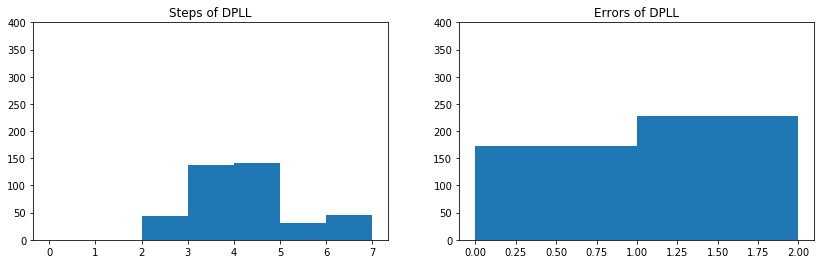

#Sats: 400; avg step: 3.75; stdev step: 1.24; avg error: 0.67; stdev error: 0.68


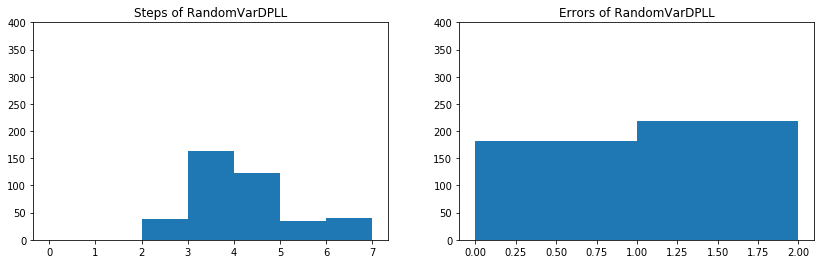

#Sats: 400; avg step: 2.99; stdev step: 0.84; avg error: 0.15; stdev error: 0.36


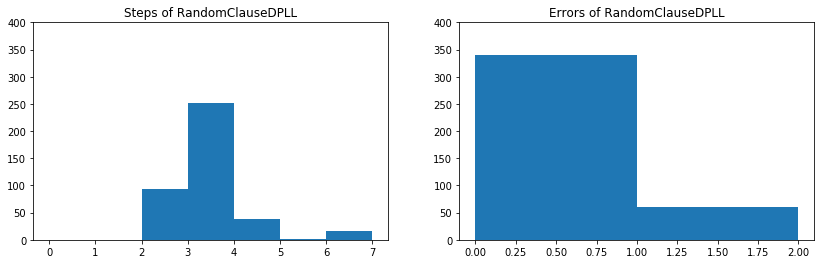

#Sats: 400; avg step: 3.01; stdev step: 0.77; avg error: 0.05; stdev error: 0.22


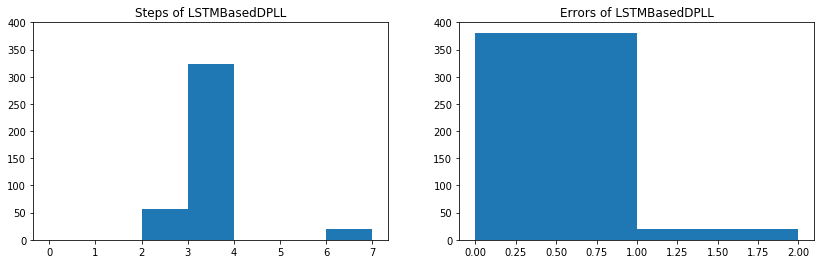

#Sats: 400; avg step: 2.65; stdev step: 0.49; avg error: 0.01; stdev error: 0.07


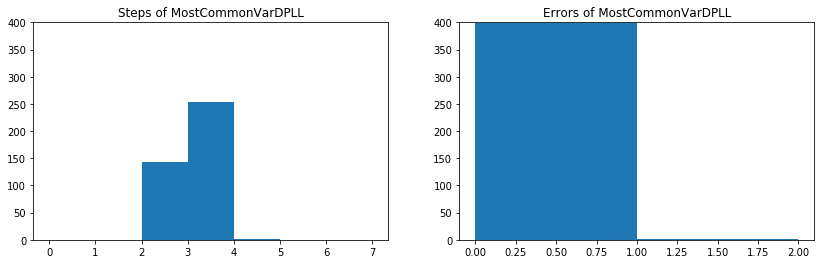

In [13]:
print_all(400, 2, 2, 3)

#Sats: 100; avg step: 8.81; stdev step: 2.58; avg error: 2.12; stdev error: 0.96


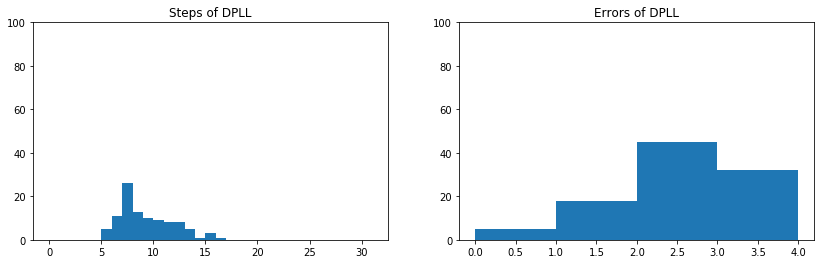

#Sats: 100; avg step: 8.48; stdev step: 2.82; avg error: 1.96; stdev error: 1.00


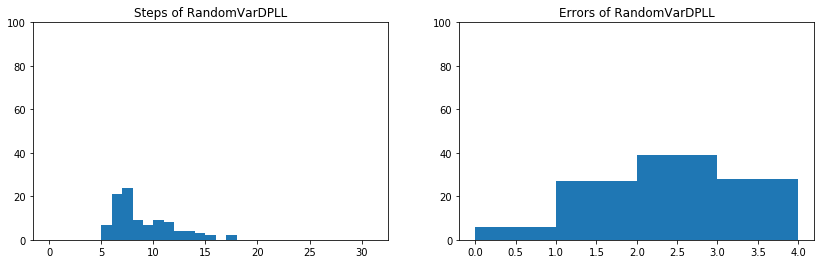

#Sats: 100; avg step: 6.79; stdev step: 2.29; avg error: 0.85; stdev error: 0.80


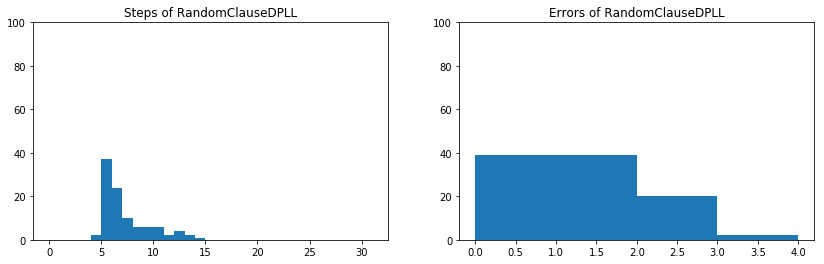

#Sats: 100; avg step: 6.21; stdev step: 2.30; avg error: 0.27; stdev error: 0.47


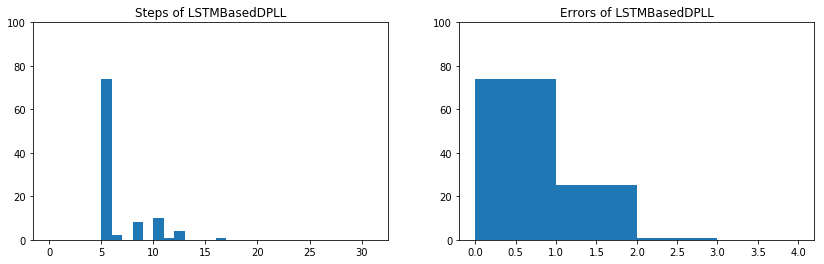

#Sats: 100; avg step: 5.11; stdev step: 0.69; avg error: 0.06; stdev error: 0.24


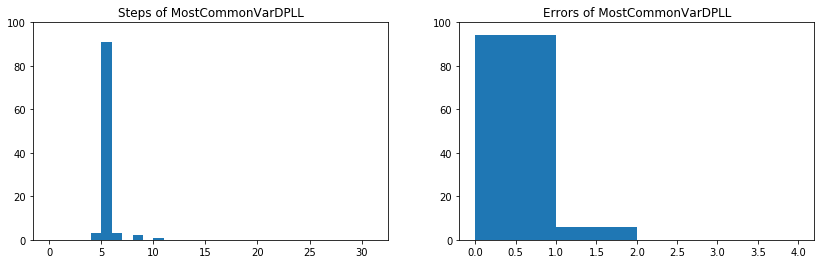

In [14]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.13; stdev step: 3.25; avg error: 1.03; stdev error: 0.90


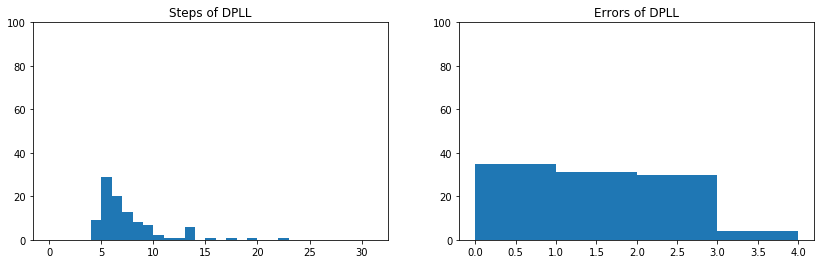

#Sats: 100; avg step: 7.37; stdev step: 3.39; avg error: 1.01; stdev error: 0.87


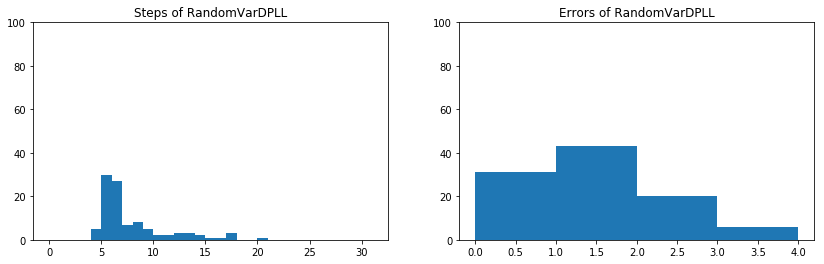

#Sats: 100; avg step: 5.73; stdev step: 2.65; avg error: 0.40; stdev error: 0.58


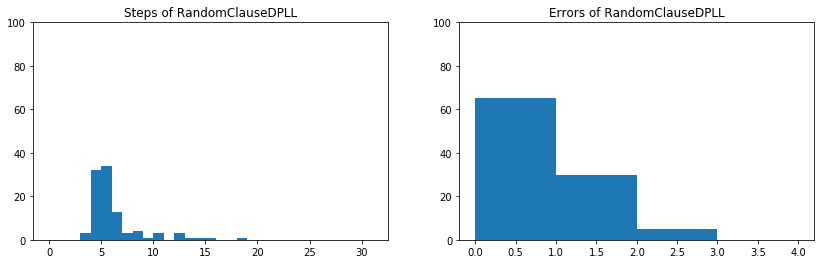

#Sats: 100; avg step: 5.46; stdev step: 2.73; avg error: 0.09; stdev error: 0.29


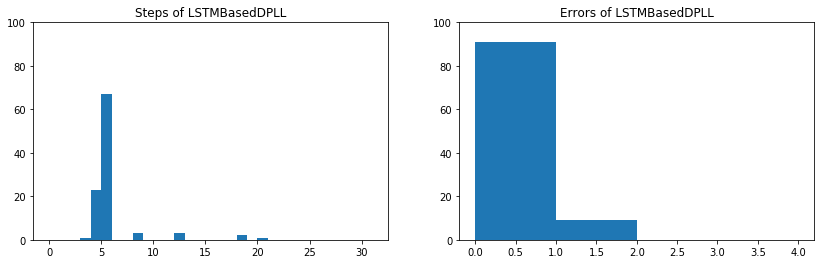

#Sats: 100; avg step: 4.75; stdev step: 1.66; avg error: 0.19; stdev error: 0.42


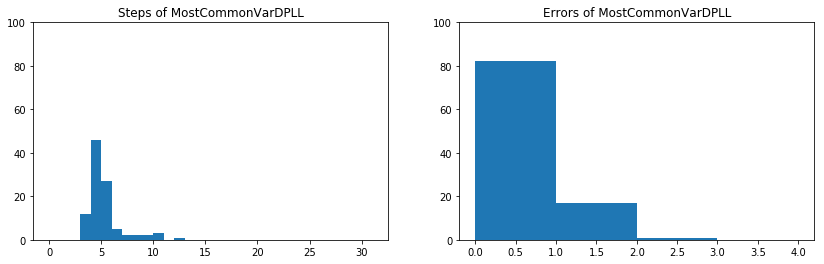

In [15]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 9.41; stdev step: 4.18; avg error: 1.71; stdev error: 0.98


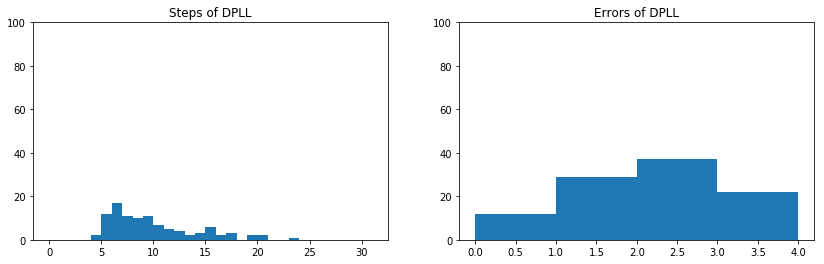

#Sats: 100; avg step: 9.43; stdev step: 4.59; avg error: 1.55; stdev error: 1.07


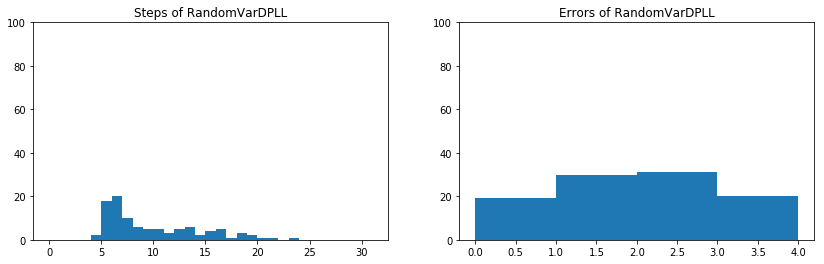

#Sats: 100; avg step: 8.01; stdev step: 3.85; avg error: 0.83; stdev error: 0.76


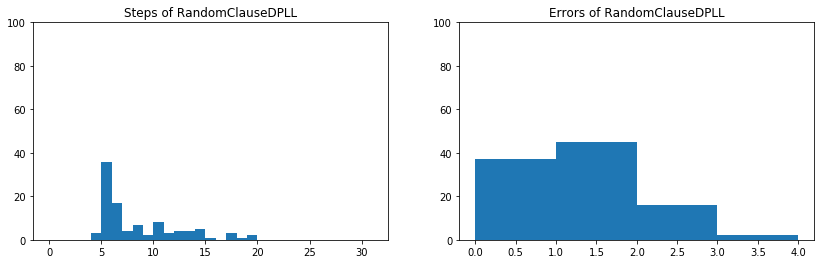

#Sats: 100; avg step: 6.72; stdev step: 3.68; avg error: 0.27; stdev error: 0.47


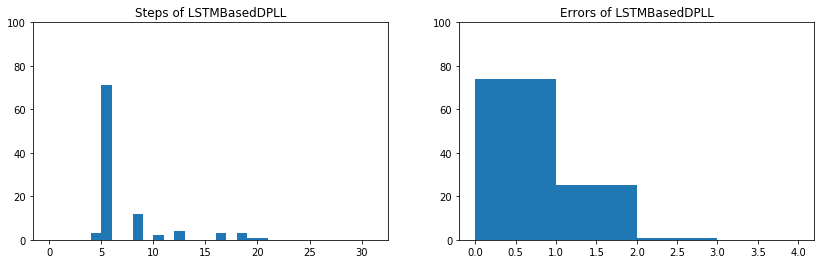

#Sats: 100; avg step: 6.04; stdev step: 2.60; avg error: 0.35; stdev error: 0.54


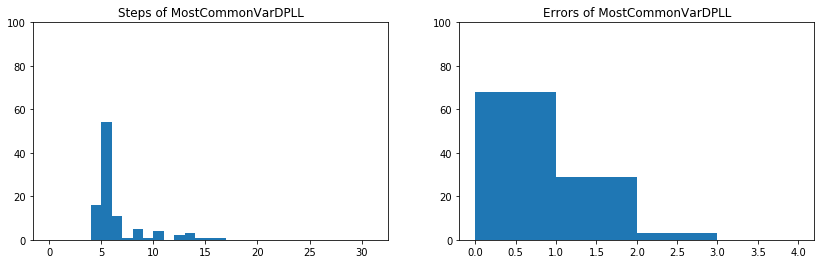

In [16]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.20; stdev step: 3.92; avg error: 1.96; stdev error: 1.00


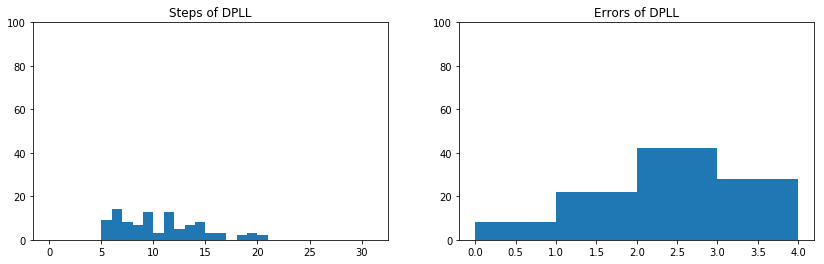

#Sats: 100; avg step: 10.42; stdev step: 3.74; avg error: 1.99; stdev error: 0.95


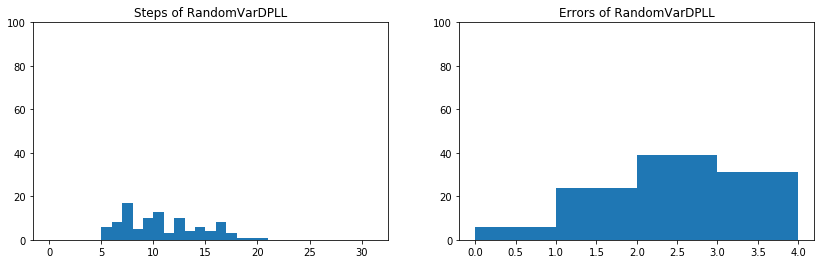

#Sats: 100; avg step: 8.58; stdev step: 3.40; avg error: 1.23; stdev error: 0.90


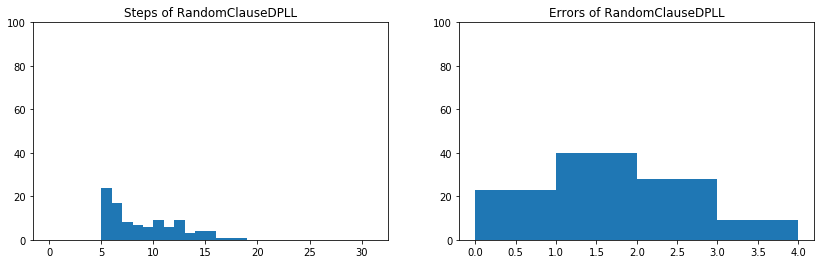

#Sats: 100; avg step: 7.78; stdev step: 3.70; avg error: 0.56; stdev error: 0.65


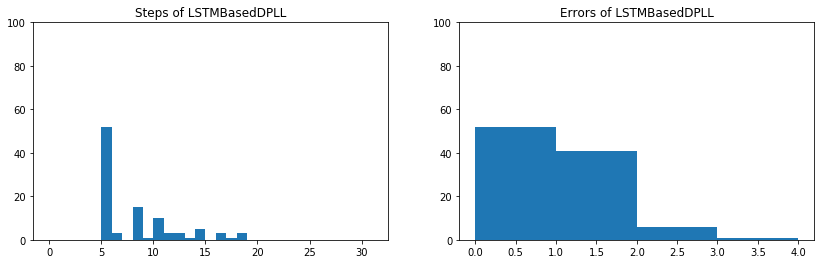

#Sats: 100; avg step: 5.91; stdev step: 2.35; avg error: 0.25; stdev error: 0.46


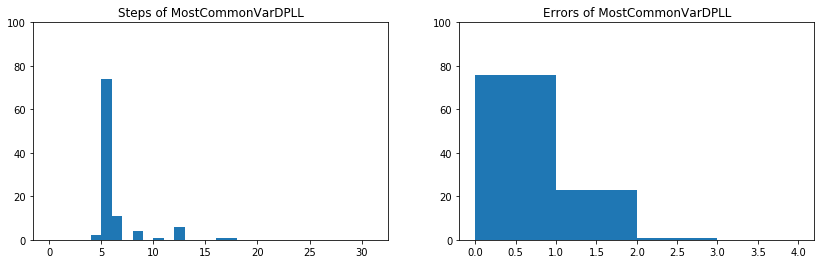

In [17]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 16.19; stdev step: 8.95; avg error: 2.43; stdev error: 1.14


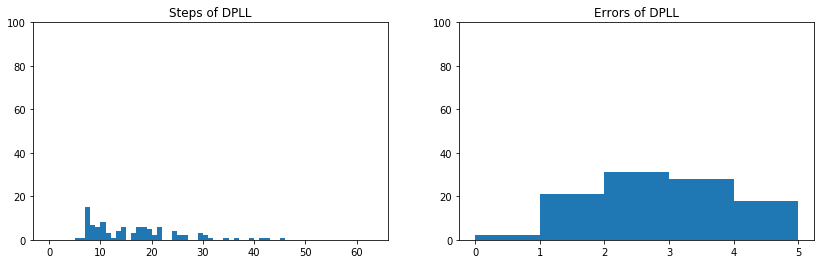

#Sats: 100; avg step: 15.57; stdev step: 7.37; avg error: 2.21; stdev error: 1.08


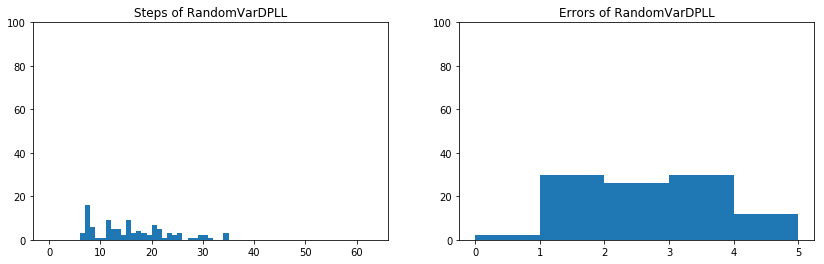

#Sats: 100; avg step: 12.50; stdev step: 6.70; avg error: 1.28; stdev error: 0.96


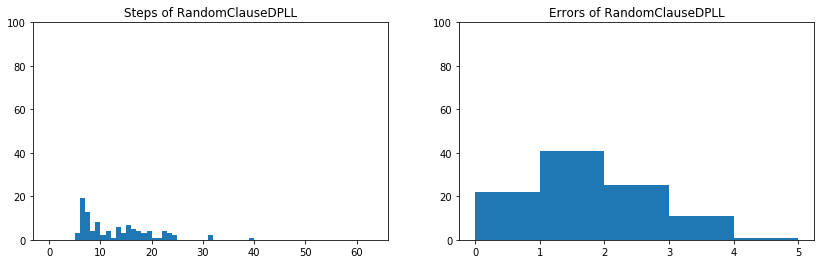

#Sats: 100; avg step: 10.97; stdev step: 7.65; avg error: 0.46; stdev error: 0.57


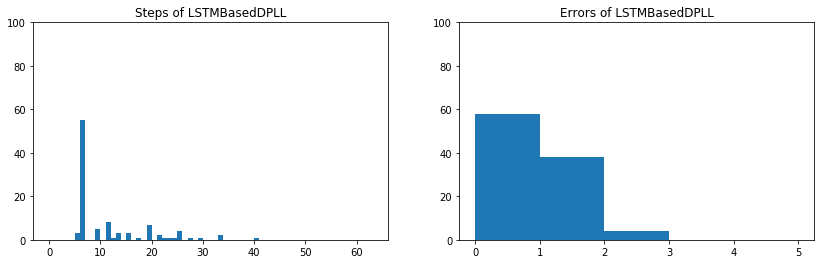

#Sats: 100; avg step: 8.14; stdev step: 4.07; avg error: 0.48; stdev error: 0.67


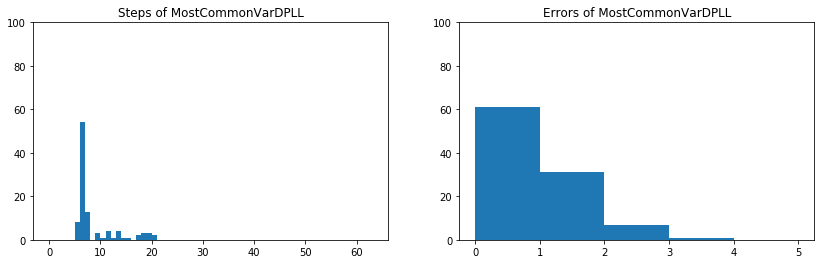

In [18]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 13.24; stdev step: 5.74; avg error: 2.36; stdev error: 1.02


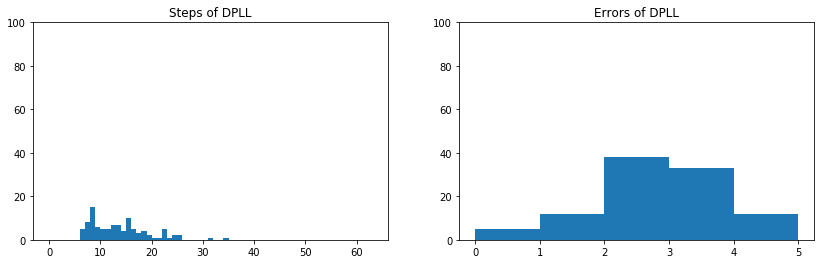

#Sats: 100; avg step: 13.87; stdev step: 6.41; avg error: 2.27; stdev error: 1.18


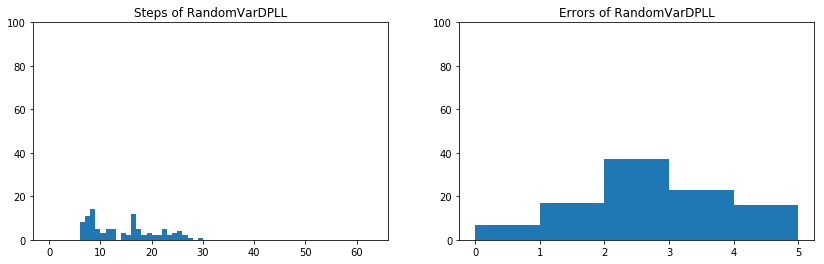

#Sats: 100; avg step: 12.67; stdev step: 5.99; avg error: 1.41; stdev error: 0.91


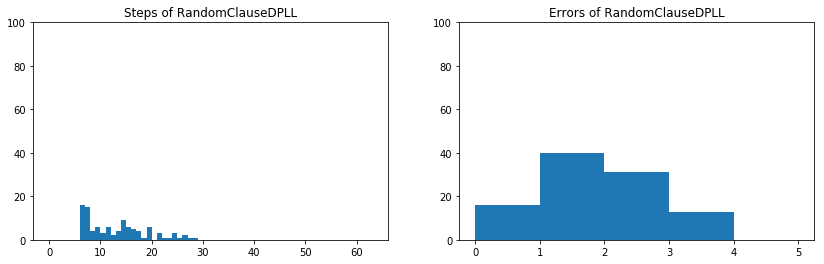

#Sats: 100; avg step: 10.48; stdev step: 6.76; avg error: 0.48; stdev error: 0.67


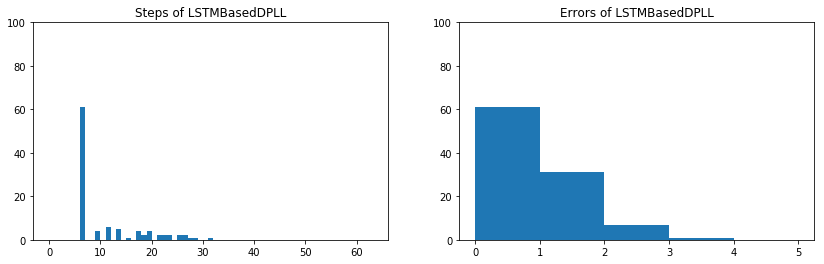

#Sats: 100; avg step: 7.92; stdev step: 3.60; avg error: 0.47; stdev error: 0.64


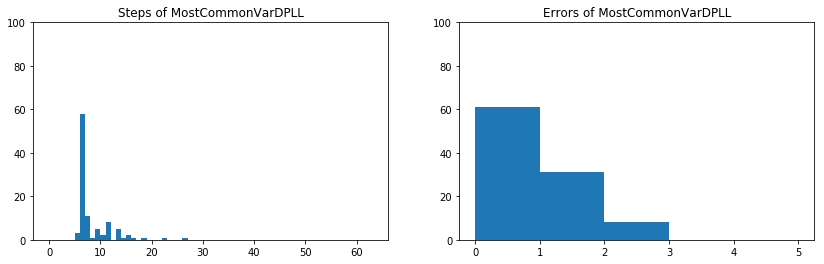

In [19]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 20.84; stdev step: 9.99; avg error: 2.98; stdev error: 1.17


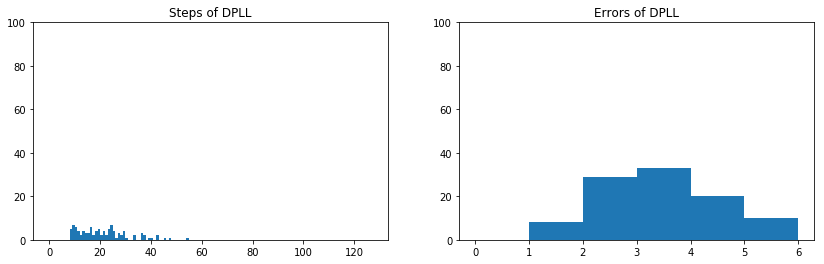

#Sats: 100; avg step: 21.30; stdev step: 11.49; avg error: 2.94; stdev error: 1.29


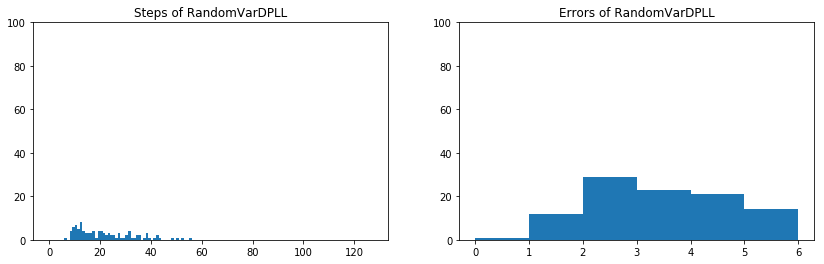

#Sats: 100; avg step: 16.53; stdev step: 9.06; avg error: 1.71; stdev error: 1.17


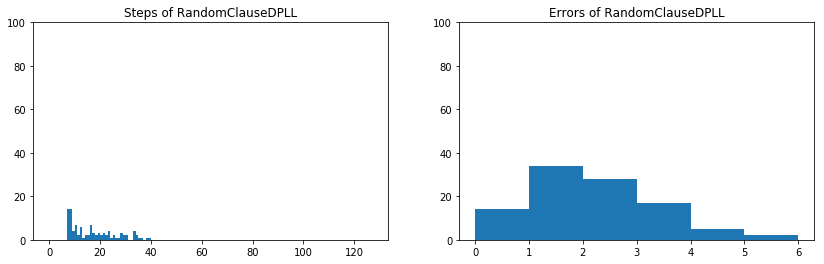

#Sats: 100; avg step: 16.79; stdev step: 12.01; avg error: 0.69; stdev error: 0.77


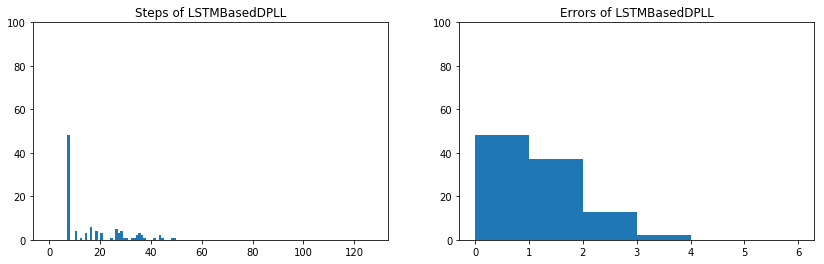

#Sats: 100; avg step: 10.16; stdev step: 5.28; avg error: 0.53; stdev error: 0.64


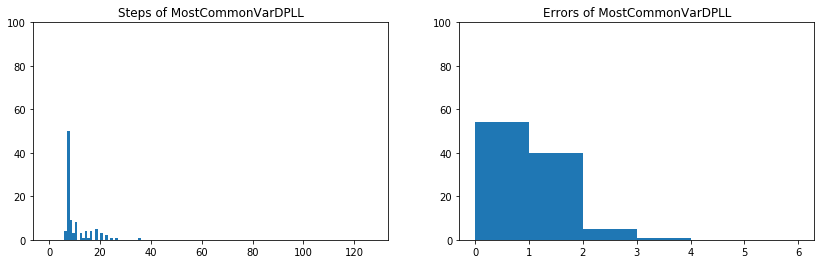

In [20]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 19.41; stdev step: 7.74; avg error: 3.23; stdev error: 1.16


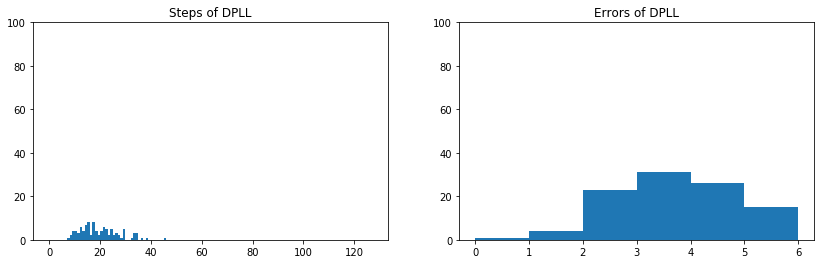

#Sats: 100; avg step: 17.50; stdev step: 6.44; avg error: 3.06; stdev error: 1.12


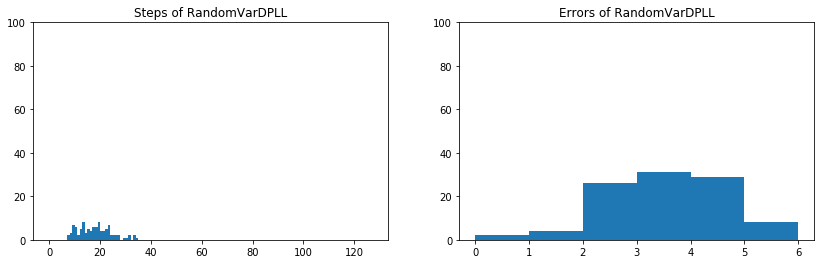

#Sats: 100; avg step: 13.74; stdev step: 5.67; avg error: 1.78; stdev error: 1.04


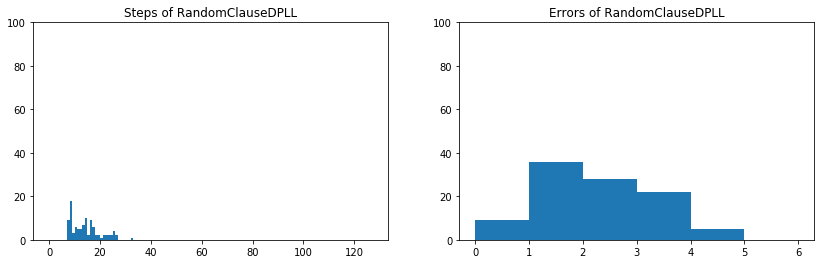

#Sats: 100; avg step: 16.45; stdev step: 10.11; avg error: 0.99; stdev error: 0.92


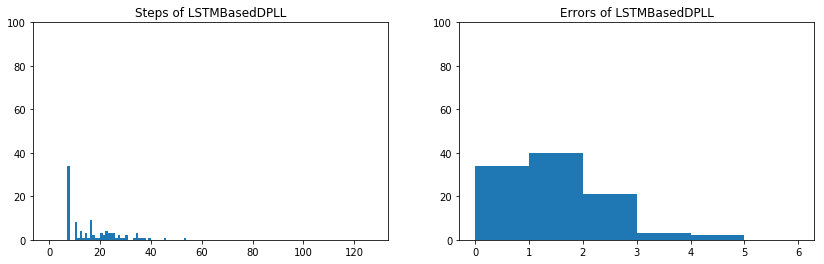

#Sats: 100; avg step: 8.49; stdev step: 3.72; avg error: 0.29; stdev error: 0.50


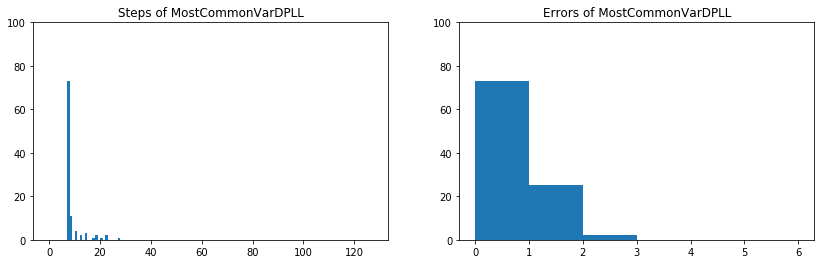

In [21]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 19.76; stdev step: 17.42; avg error: 2.07; stdev error: 1.25


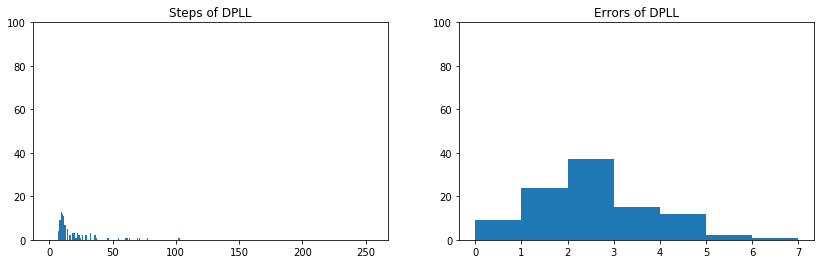

#Sats: 100; avg step: 19.17; stdev step: 13.95; avg error: 2.00; stdev error: 1.09


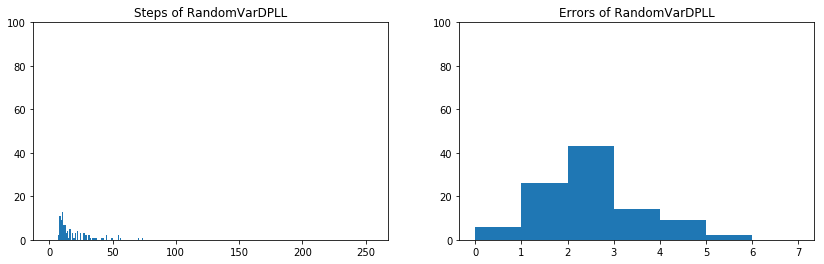

#Sats: 100; avg step: 12.66; stdev step: 9.94; avg error: 0.84; stdev error: 1.00


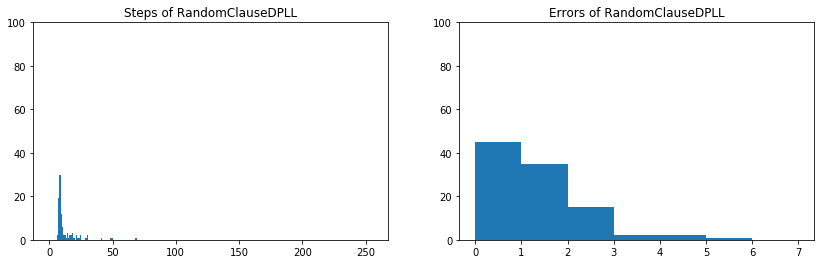

#Sats: 100; avg step: 13.20; stdev step: 15.09; avg error: 0.25; stdev error: 0.54


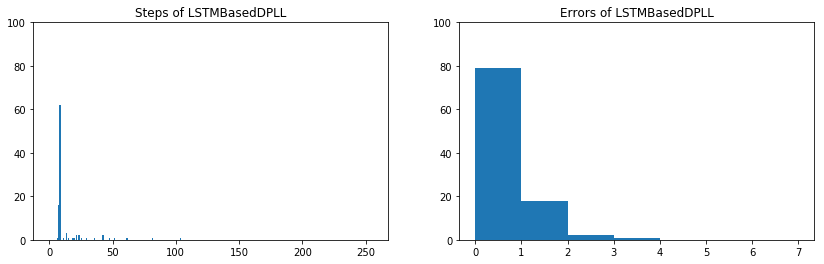

#Sats: 100; avg step: 7.62; stdev step: 3.21; avg error: 0.27; stdev error: 0.56


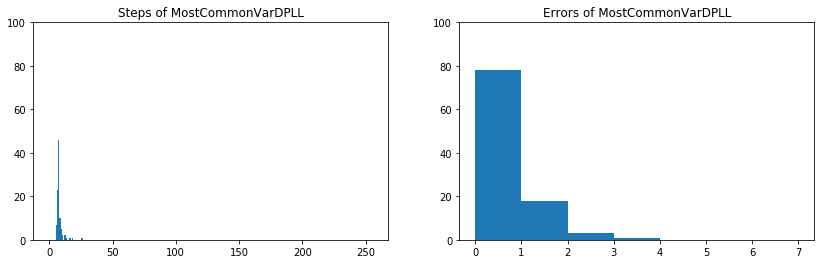

In [22]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 23.00; stdev step: 10.89; avg error: 3.52; stdev error: 1.28


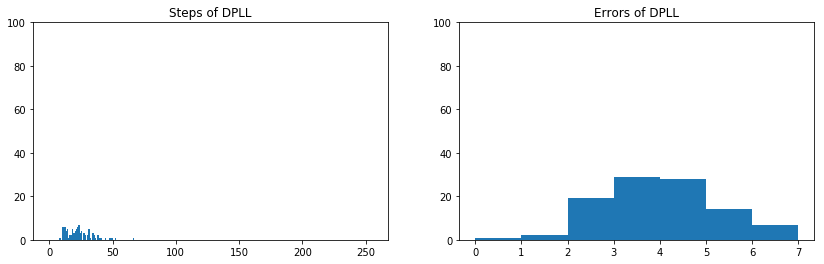

#Sats: 100; avg step: 23.28; stdev step: 9.56; avg error: 3.32; stdev error: 1.22


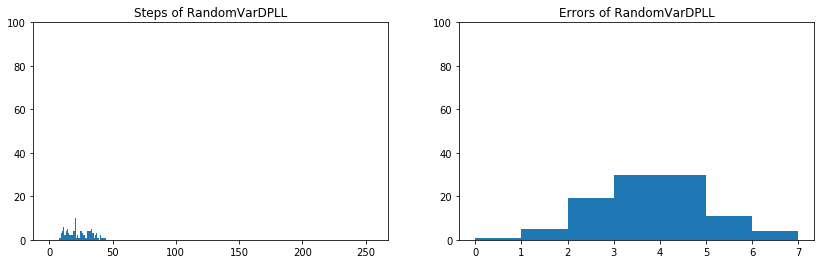

#Sats: 100; avg step: 20.81; stdev step: 9.66; avg error: 2.37; stdev error: 1.01


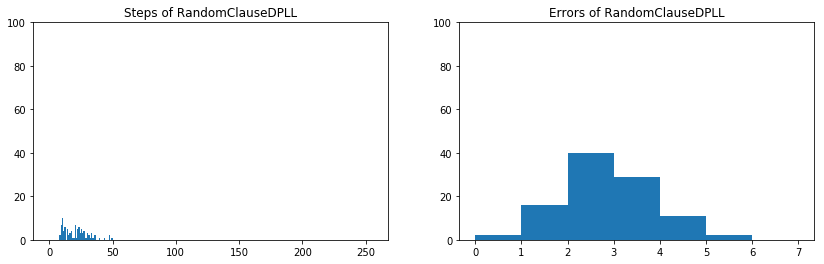

#Sats: 100; avg step: 20.35; stdev step: 13.94; avg error: 0.87; stdev error: 0.80


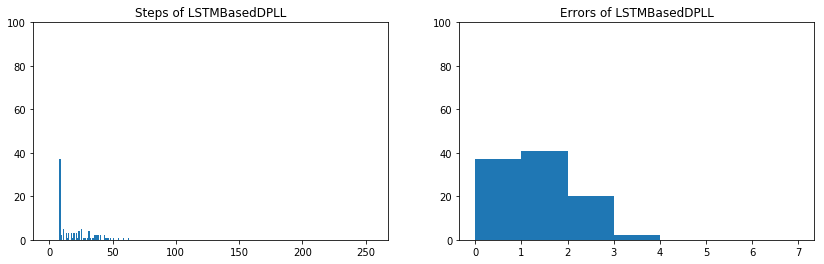

#Sats: 100; avg step: 9.73; stdev step: 4.35; avg error: 0.35; stdev error: 0.54


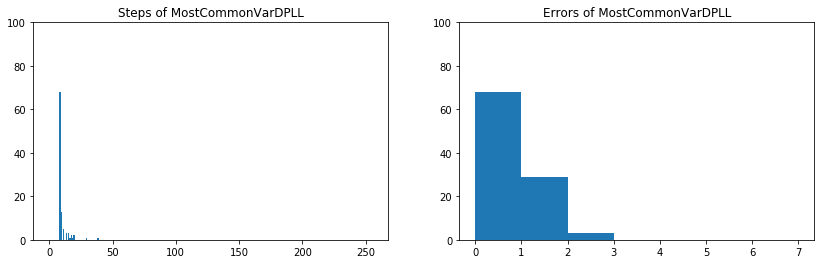

In [23]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 37.72; stdev step: 28.79; avg error: 3.36; stdev error: 1.42


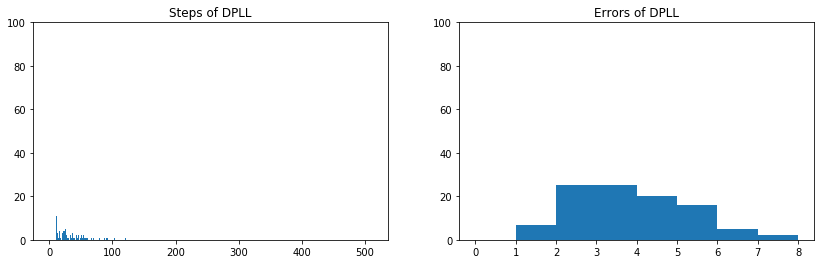

#Sats: 100; avg step: 38.03; stdev step: 23.55; avg error: 3.48; stdev error: 1.53


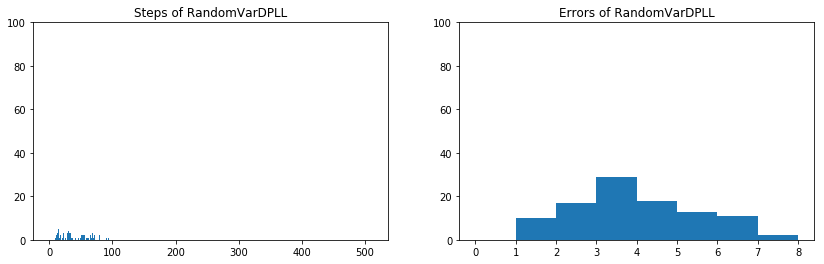

#Sats: 100; avg step: 26.08; stdev step: 19.38; avg error: 1.72; stdev error: 1.11


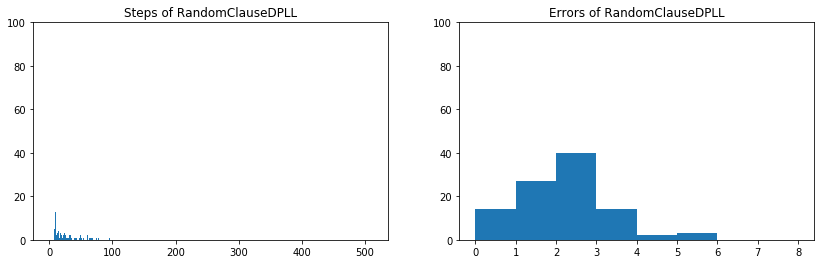

#Sats: 100; avg step: 29.84; stdev step: 29.58; avg error: 0.73; stdev error: 0.77


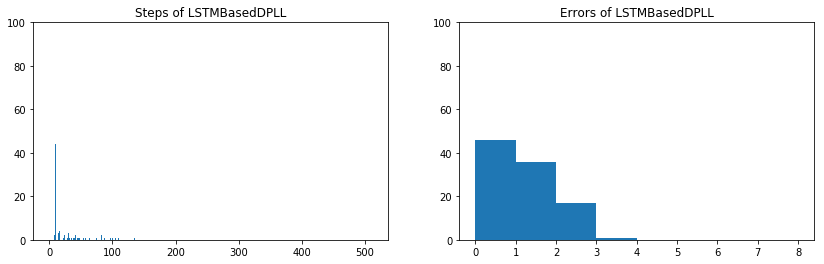

#Sats: 100; avg step: 16.45; stdev step: 11.99; avg error: 0.73; stdev error: 0.73


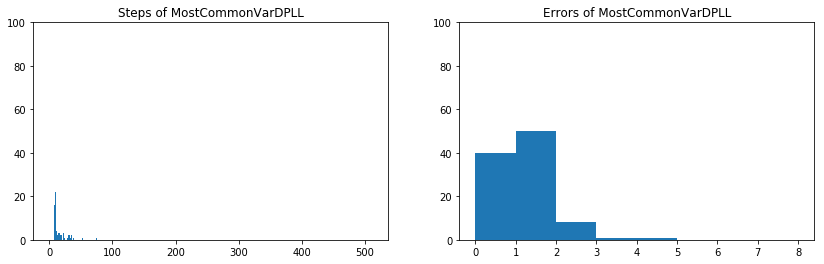

In [24]:
print_all(100, 3, 8, 40)

#Sats: 100; avg step: 41.03; stdev step: 24.32; avg error: 3.76; stdev error: 1.27


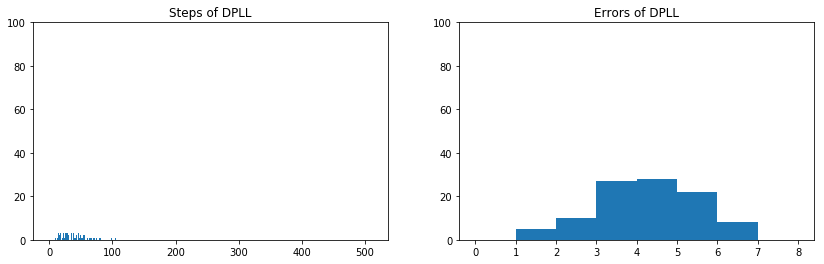

#Sats: 100; avg step: 37.86; stdev step: 22.20; avg error: 3.78; stdev error: 1.31


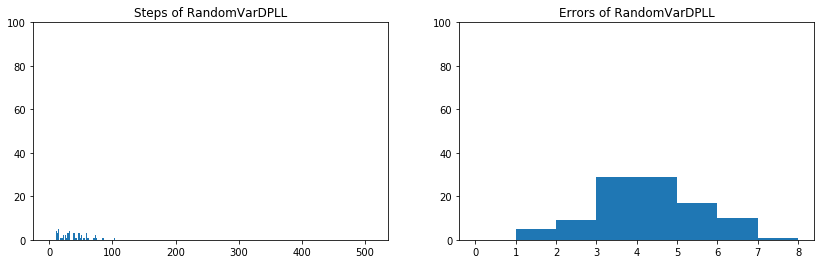

#Sats: 100; avg step: 29.15; stdev step: 16.69; avg error: 2.27; stdev error: 1.26


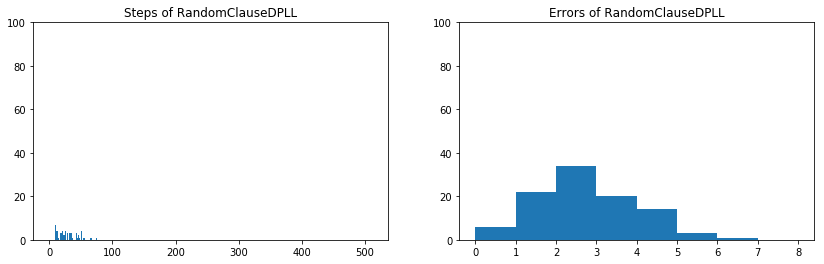

#Sats: 100; avg step: 32.59; stdev step: 30.44; avg error: 0.86; stdev error: 0.84


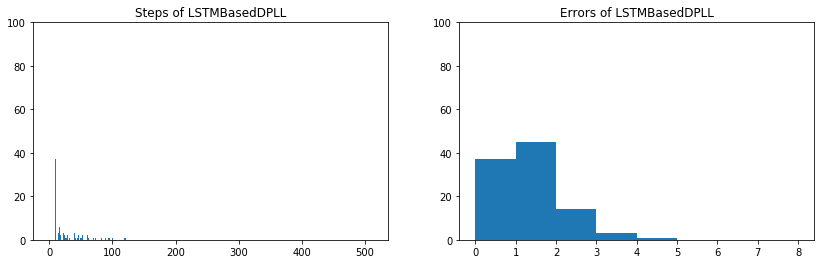

#Sats: 100; avg step: 17.47; stdev step: 10.67; avg error: 0.80; stdev error: 0.69


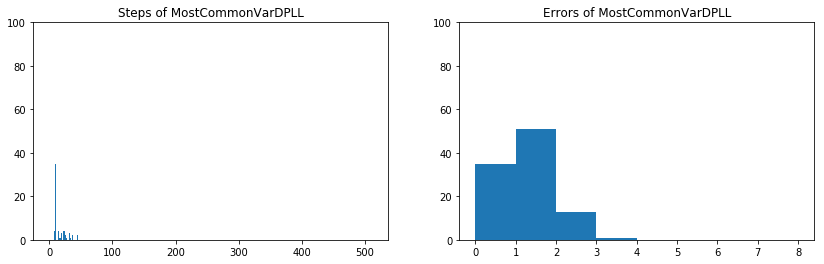

In [25]:
print_all(100, 3, 8, 50)

#Sats: 100; avg step: 75.17; stdev step: 48.35; avg error: 4.54; stdev error: 1.57


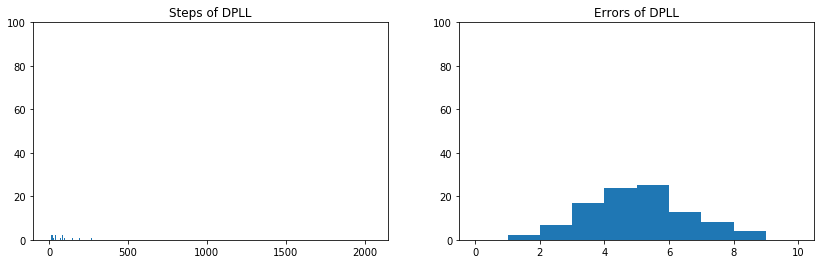

#Sats: 100; avg step: 77.49; stdev step: 49.89; avg error: 4.53; stdev error: 1.46


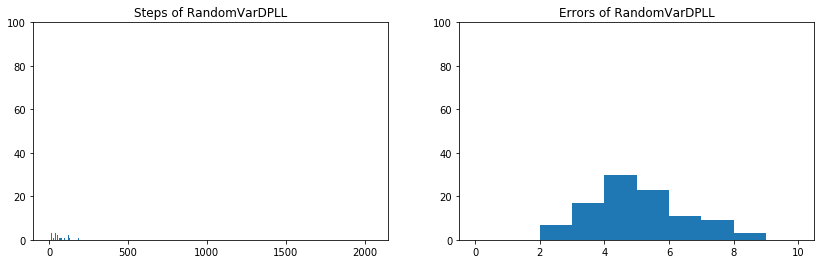

#Sats: 100; avg step: 54.27; stdev step: 37.34; avg error: 2.41; stdev error: 1.30


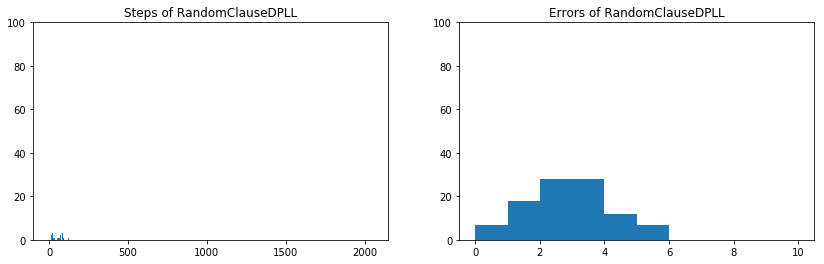

#Sats: 100; avg step: 67.60; stdev step: 87.93; avg error: 0.88; stdev error: 0.89


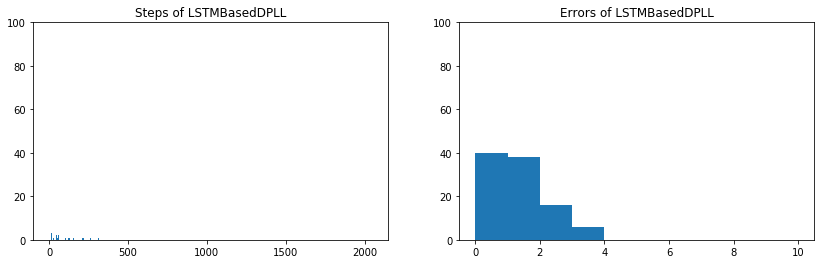

#Sats: 100; avg step: 22.00; stdev step: 16.68; avg error: 0.87; stdev error: 0.80


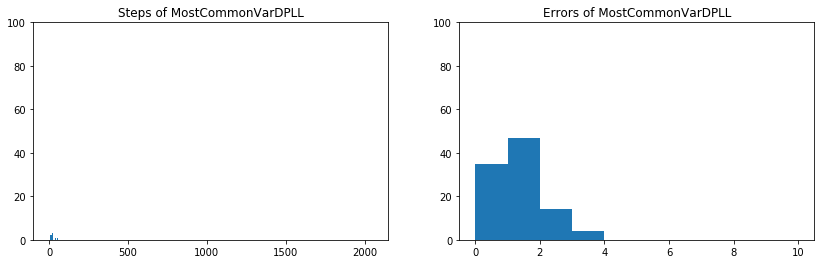

In [26]:
print_all(100, 3, 10, 50)